# OpenSeesPy Script: Nonlinear model of a Frame and Dynamic analysis including forces, displacements, drifts and accelerations
#### Autor: Orlando Arroyo
#### email: odarroyo@uc.cl
#### based on the example available at: https://opensees.berkeley.edu/wiki/index.php?title=OpenSees_Example_5._2D_Frame,_3-story_3-bay,_Reinforced-Concrete_Section_%26_Steel_W-Section

## Loading required libraries

In [2]:
from openseespy.opensees import *
import opsvis as opsv # You need to call opsvis to plot the model being generated.
import matplotlib.pyplot as plt # This is a standard library for plotting various elements and creating figures..
import opseestools.analisis as an # Analysis library with various options.
import numpy as np # Numpy library for mathematical operations.


## Model creation

In [3]:
wipe() # It is good practice to start with a wipe.
model('basic','-ndm',2,'-ndf',3) # Creation of a two-dimensional model with three degrees of freedom per node.


## Definition of nodes and supports

<Axes: >

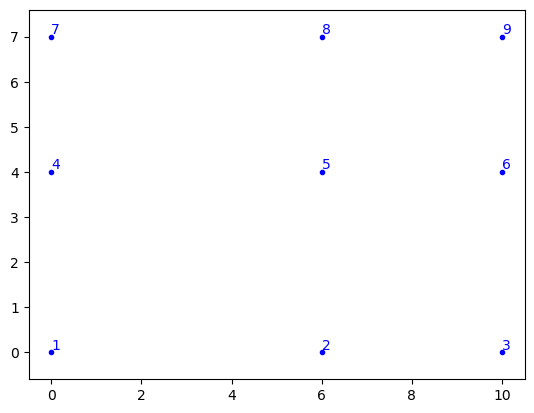

In [4]:
x1 = 6.0
x2 = 10.0
y1 = 4.0
y2 = 7.0

node(1,0.0,0.0) # Definition of node 1 with X and Y coordinates of 0.0 and 0.0.
node(2,x1,0.0)
node(3,x2,0.0)
node(4,0.0,y1)
node(5,x1,y1)
node(6,x2,y1)
node(7,0.0,y2)
node(8,x1,y2)
node(9,x2,y2)

# Construction supports
empotrado = [1,1,1] # Restrict degrees of freedom X, Y, and Z.
grado2 = [1,1,0] # Restrict degrees of freedom X and Y, leaving Z free.

fix(1,*empotrado)
fix(2,*empotrado)
fix(3,*grado2)

# Visualization of the nodes
opsv.plot_model()

## Definition of diaphragms and masses

In [5]:
# Diaphragms
equalDOF(4,5,1) # Make the displacement of node 5 in X equal to that of node 4.
equalDOF(4,6,1)
equalDOF(7,8,1) 
equalDOF(7,9,1)

# Masses
mass(4,1,1,0) # Assignment of masses in X and Y to node 4.
mass(5,1,1,0)
mass(6,1,1,0)
mass(7,1,1,0)
mass(8,1,1,0)
mass(9,1,1,0)

## Definition of materials

In [6]:
# Unconfined concrete
E = 24000000.0 # 24 GPa converted to kPa to make it consistent.
fc = 28000.0
ec = 2*fc/E
fcu = 0.2*fc
ecu = 0.006

# Confined concrete
k=1.3
fcc=28000.0*k
ecc= 2*fcc/E
fucc=0.2*fcc
eucc=0.02

# Steel
Fy=420000.0
Es=210000000.0

uniaxialMaterial('Concrete01', 2, fc, ec, fcu, ecu)
uniaxialMaterial('Concrete01', 1, fcc, ecc, fucc, eucc)
uniaxialMaterial('Steel01', 3, Fy, Es, 0.01)

## Fiber section creation


<Figure size 640x480 with 0 Axes>

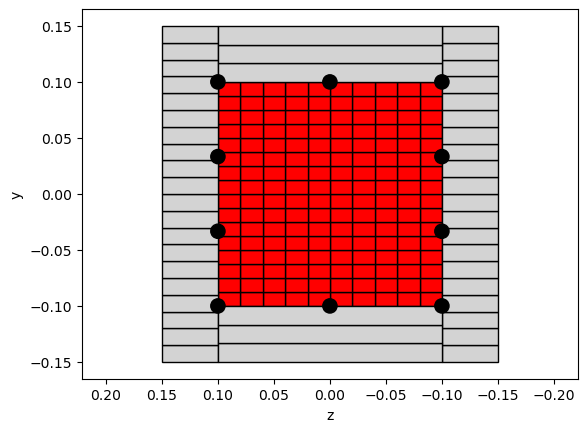

In [7]:
# An example of fiber section creation
# Section of 30 x 30 cm with 8 # 4

Bcol = 0.3
Hcol = 0.3
c = 0.05  # Covering 

# Fiber section creation
y1col = Hcol/2.0
z1col = Bcol/2.0

y2col = 0.5*(Hcol-2*c)/3.0

nFibZ = 1
nFibZcore= 10
nFib = 20
nFibCover, nFibCore = 3, 16
As4 = 0.000127
As5 = 0.0002
As7 = 0.000387

sec30x30 = 1 # Tag section.

# The opsvis library will be used to visualize the section
s30x30 = [['section', 'Fiber', sec30x30, '-GJ', 1.0e6],
             ['patch', 'rect', 1, nFibCore, nFibZcore, c-y1col, c-z1col, y1col-c, z1col-c],
             ['patch', 'rect', 2, nFib, nFibZ, -y1col, -z1col, y1col, c-z1col],
             ['patch', 'rect', 2, nFib, nFibZ, -y1col, z1col-c, y1col, z1col],
             ['patch', 'rect', 2, nFibCover, nFibZ, -y1col, c-z1col, c-y1col, z1col-c],
             ['patch', 'rect', 2, nFibCover, nFibZ, y1col-c, c-z1col, y1col, z1col-c],
             ['layer', 'straight', 3, 3, As4, y1col-c, z1col-c, y1col-c, c-z1col],
             ['layer', 'straight', 3, 2, As4, y2col, z1col-c, y2col, c-z1col],
             ['layer', 'straight', 3, 2, As4, -y2col, z1col-c, -y2col, c-z1col],
             ['layer', 'straight', 3, 3, As4, c-y1col, z1col-c, c-y1col, c-z1col]]

# The following commands draw the section to verify that everything is correct
matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
plt.figure()
opsv.plot_fiber_section(s30x30, matcolor=matcolor)
plt.axis('equal')

# The following command properly creates the section by executing the code defined in the list
opsv.fib_sec_list_to_cmds(s30x30)

# To generate the fiber elements, you need to specify the integration points and the integration scheme
pint = 5 # Integration points
beamIntegration('Lobatto', sec30x30, sec30x30,pint) # Integration scheme

## Definition of elements

<Axes: >

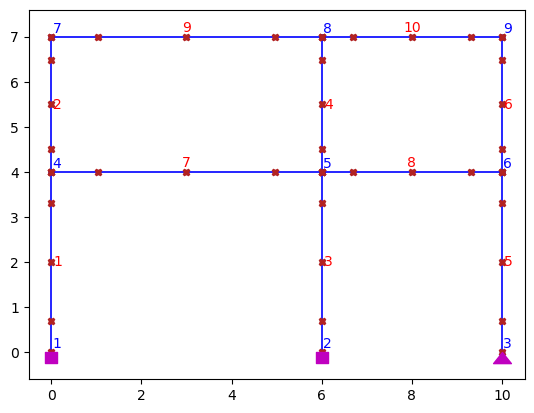

In [8]:
# Element transformations
lineal = 1
geomTransf('Linear',lineal) # Linear transformation

pdelta = 2
geomTransf('PDelta',pdelta) # PDelta transformation

# Columns
element('forceBeamColumn',1, 1,4 ,pdelta,sec30x30)
element('forceBeamColumn',2, 4,7 ,pdelta,sec30x30)
element('forceBeamColumn',3, 2,5 ,pdelta,sec30x30)
element('forceBeamColumn',4, 5,8 ,pdelta,sec30x30)
element('forceBeamColumn',5, 3,6 ,pdelta,sec30x30) 
element('forceBeamColumn',6, 6,9 ,pdelta,sec30x30) 

# Beams
element('forceBeamColumn',7, 4,5 ,lineal,sec30x30)
element('forceBeamColumn',8, 5,6 ,lineal,sec30x30)
element('forceBeamColumn',9, 7,8 ,lineal,sec30x30) 
element('forceBeamColumn',10, 8,9 ,lineal,sec30x30) 

# Visualize the model
opsv.plot_model()

#### The red points correspond to the locations of the integration points

## Model loads

In [9]:
timeSeries('Linear', 1)
pattern('Plain',1,1)
# The eleload command assigns a load to the element:
vigas = [7,8,9,10] # Element tags beams
wviga = 20 # Distributed load on the beam
eleLoad('-ele',*vigas,'-type','beamUniform',-wviga) # Application of the load on the beam

## Calculation of eigenvalues and modal shapes

The fundamental period is:  0.241677010681145


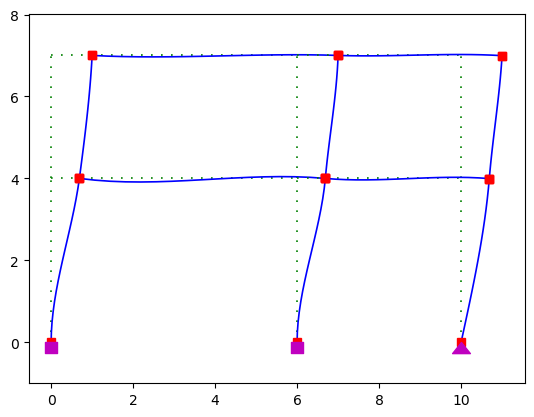

In [10]:
eig= eigen(1) # The `eigen` command calculates the frequencies for the specified number of modes. In this case, 1 mode is specified.
T1 = 2*3.1416/np.sqrt(eig[0]) # The corresponding period is obtained.
print('El periodo fundamental es: ',T1) # Se imprime el resultado.

# Visualization of the first modal shape
opsv.plot_mode_shape(1)

## Analysis of the model and representation of the deformation

201.77589274222515

<Figure size 640x480 with 0 Axes>

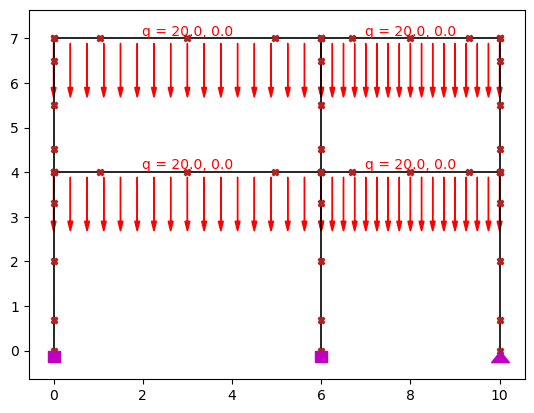

<Figure size 640x480 with 0 Axes>

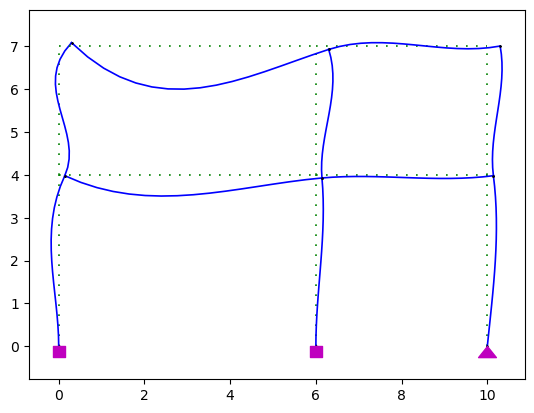

In [11]:
# The analysis library that was called is used.

an.gravedad()
loadConst('-time',0.0) # This command leaves the gravity loads fixed

# Model representation with loads
plt.figure()
opsv.plot_loads_2d()

# Deformed representation
plt.figure()
opsv.plot_defo()

## Dynamic analysis

##### Analysis 

The analysis library is used and is called dinamicoIDA4P(recordName,dtrec,nPts,dtan,fact,damp,IDctrlNode,IDctrlDOF,elements,nodes_control)

1) record is the name of the record, including extension. P.ej. GM01.txt

2) dtrec is the dt of record

3) nPts is the number of points in the analysis

4) dtan is the dt of analysis

5) fact is the scalar factor of the record

6) damp is the percentage of damping (IN DECIMAL. p.ej: 0.03 para 3%)

7) IDcrtlNode is the node for recording offsets

8) IDctrlDOF is the degree of freedom of control

9) elements are the elements to which the information will be recorded

10) nodes_control are the control nodes for each floor of the building.

The outputs are in the following order: time, roof displacement, forces on elements, displacements on nodes, velocities on nodes, accelerations, drifts.


In [12]:
tiempo,techo,Eds,node_disp,node_vel,node_acel,drift = an.dinamicoIDA4P('GM01.txt',0.01,3000,0.01,1.0,0.03,9,1,[1,3,5],[3,6,9])

Text(0, 0.5, 'desplazamiento (m)')

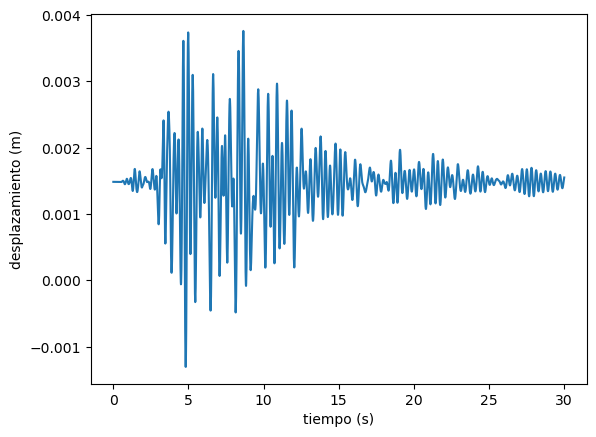

In [13]:
plt.plot(tiempo,techo)
plt.xlabel('tiempo (s)')
plt.ylabel('desplazamiento (m)')
plt.show()